In [47]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data

from tqdm.notebook import tqdm

Thus you are not allowed to use cv2.matchTemplate, cv2.stereoBM or similar functions from opencv or other pre-existing libraries. 

### Step 1
Function for calculating the sum of absolete differences

In [48]:
def calc_diff(img_1, img_2):
    assert img_1.shape == img_2.shape, "size of the images is supposed to be the same"
    
    diff = np.abs(np.sum(img_1 - img_2))
    
    return diff

In [49]:
nose_left = cv2.imread("nose_left.png")
nose_right = cv2.imread("nose_right.png")

### Step 2

Using the function you just created, find which of the three images nose1.png, nose2.png, nose3.png gives the best match to nose_left.png?

best score: 13113


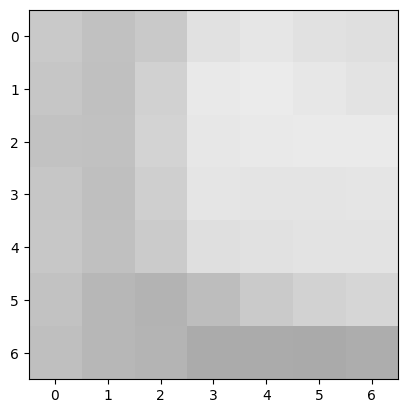

In [50]:
best_score = 0
best_image = None

images_names = ["nose1.png", "nose2.png", "nose3.png"]

for i, image_name in enumerate(images_names):
    img = cv2.imread(image_name)
    
    diff = calc_diff(img, nose_left)
    
    # print(f"i: {i}, diff: {diff}")
    
    if i == 0:
        best_score = diff
        best_image = np.copy(img)
    else:
        if diff < best_score:
            best_score = diff
            best_image = np.copy(img)

print(f"best score: {best_score}")

plt.imshow(best_image)

### Step 3

Write a function that loops through the image from left to right and computes the correlation using your function from step 1 to find where in the span the nose is located.

In [51]:
row_img = cv2.imread("nose_span.png")

print(row_img.shape)

padded_arr = np.pad(row_img, pad_width=((0, 0), (3, 3), (0, 0)), mode='constant', constant_values=0)

print(padded_arr.shape)

(7, 384, 3)
(7, 390, 3)


In [52]:


def calc_diff_in_row(row_img, img):
    best_score = 0
    best_image = None
    best_index = 0
    for i in range(row_img.shape[1] - 7):
    # for i in range(1):
        
        row_img_window = row_img[:, i:i+7]
        
        # print(row_img_window.shape)
        # print(img.shape)
        
        diff = calc_diff(row_img_window, img)
        
        # print(diff)
        
        # f, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18,18))
        # ax_left.imshow(row_img_window)
        # ax_right.imshow(img)
        
        if i == 0:
            best_score = diff
            best_index = i
        else:
            if diff < best_score:
                best_score = diff
                best_index = i
    
    return best_index
    

nose_3 = cv2.imread("nose3.png")

row_img_grey = cv2.cvtColor(row_img, cv2.COLOR_BGR2GRAY)
nose_left_grey = cv2.cvtColor(nose_3, cv2.COLOR_BGR2GRAY)

print(row_img_grey.shape)
print(nose_left_grey.shape)

best_index = calc_diff_in_row(row_img_grey, nose_left_grey)

print(f"best score: {best_score}")
print(f"best index: {best_index}")

# plt.imshow(best_img)

(7, 384)
(7, 7)
best score: 13113
best index: 157


### Challenge

Write a template matching function that iteratively takes a 7x7 subpart (numpy calls this slicing) of tsukuba_left.png and uses your function from step 3 to apply it to the corresponding row in tsukuba_right.png and stores the lowest/best matching disparity value for that template. Continue until all possible templates for a row has been used before moving down to the next row in the image.

In [53]:
img_1 = cv2.imread("tsukuba_left.png")
img_2 = cv2.imread("tsukuba_right.png")

print(img_1.shape)
print(img_2.shape)

img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

(288, 384, 3)
(288, 384, 3)


disparity so we need to know the difference between x position of the poxels with lowes difference

In [68]:
def match_templates(img_1, img_2):
    
    disparity_map = np.zeros(img_1.shape, dtype=np.float64)
    
    for row_id in tqdm(range(0, img_1.shape[0] - 7, 1)):
    # for row_id in range(img_1.shape[0] - 7):
        row_img = img_1[row_id:row_id+7, :]
        for column_id in range(0, img_1.shape[1] - 7, 1):
        # for column_id in range(img_1.shape[1] - 7):
            img = img_2[row_id:row_id+7, column_id:column_id+7]
            best_index = calc_diff_in_row(row_img, img)
            
            disparity_map[row_id:row_id+7, column_id:column_id+7] = column_id - best_index
            
    return disparity_map
                        
        
disparity_map = match_templates(img_1, img_2)

100%|██████████| 281/281 [04:46<00:00,  1.02s/it]


In [77]:
min_val = np.min(disparity_map)
max_val = np.max(disparity_map)

# Step 2: Scale the array to [0, 1]
normalized_array = (disparity_map - min_val) / (max_val - min_val)

# Step 3: Scale to [0, 255] and convert to integer
scaled_array = (normalized_array * 255).astype(np.uint8)

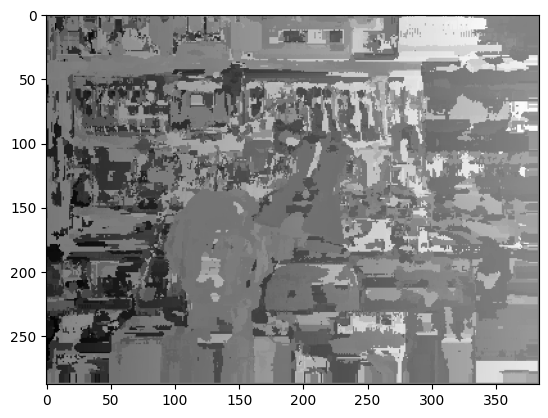

In [69]:
plt.imshow(disparity_map, cmap='gray')

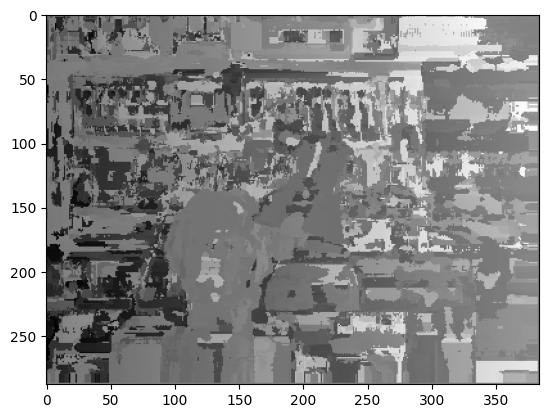

In [78]:
plt.imshow(scaled_array, cmap='gray')

In [75]:
import numpy as np
import cv2

def export_pointcloud(disparity_map):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    end_header
    '''

    def write_ply(fn, verts):
        verts = verts.reshape(-1, 3)
        with open(fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f')

    h, w = disparity_map.shape[:2]
    f = .8 * w  # guess for focal length. If you 3D reconstruction looks skewed in the viewing direction, try adjusting this parameter.
    Q = np.float32([[1, 0, 0, -0.5 * w],
                    [0, -1, 0, 0.5 * h],  # turn points 180 deg around x-axis,
                    [0, 0, 0, -f],  # so that y-axis looks up
                    [0, 0, 1, 0]])
    
    # Ensure disparity_map is float32
    disparity_map = np.array(disparity_map, dtype=np.float32)
    
    # Check values in disparity_map
    disparity_map[disparity_map <= 0] = 0.1  # Avoid zeros or negative values that might cause issues
    
    points = cv2.reprojectImageTo3D(disparity_map, Q)
    
    mask = disparity_map > disparity_map.min()
    out_points = points[mask]
    
    out_fn = 'out.ply'
    write_ply(out_fn, out_points)
    print(f'{out_fn} saved')

export_pointcloud(disparity_map=disparity_map)


out.ply saved


In [70]:
import cv2
import numpy as np
from tqdm import tqdm

# Optimized function to calculate the difference score using slicing
def calc_diff_in_row_optimized(row_img, img_patch):
    window_size = img_patch.shape[1]
    
    # Extract sliding windows efficiently using NumPy slicing
    row_windows = np.lib.stride_tricks.sliding_window_view(row_img, (row_img.shape[0], window_size), axis=1)[0]
    
    # Compute differences for all windows at once using vectorized NumPy operations
    diffs = np.sum(np.abs(row_windows - img_patch), axis=(0, 1))
    
    # Find the best match (smallest difference)
    best_index = np.argmin(diffs)
    
    return best_index

# Optimized template matching with sliding window
def match_templates_optimized(img_1, img_2, window_size=7):
    disparity_map = np.zeros((img_1.shape[0] - window_size + 1, img_1.shape[1] - window_size + 1), dtype=np.float64)

    # Use sliding window to extract patches from img_2
    img_2_windows = np.lib.stride_tricks.sliding_window_view(img_2, (window_size, window_size))
    
    # Loop through img_1 rows
    for row_id in tqdm(range(img_1.shape[0] - window_size + 1)):
        row_img = img_1[row_id:row_id + window_size, :]
        
        for column_id in range(img_1.shape[1] - window_size + 1):
            img_patch = img_2_windows[row_id, column_id]
            
            # Call optimized diff calculation
            best_index = calc_diff_in_row_optimized(row_img, img_patch)
            
            disparity_map[row_id, column_id] = column_id - best_index
    
    return disparity_map

# Run template matching
disparity_map = match_templates_optimized(img_1, img_2)

# Optionally display the results
# plt.imshow(disparity_map, cmap='gray')


  0%|          | 0/282 [00:00<?, ?it/s]


ValueError: Must provide matching length window_shape and axis; got 2 window_shape elements and 1 axes elements.

In [ ]:
plt.imshow(disparity_map, cmap='gray')